<a href="https://colab.research.google.com/github/tejasmanchi/NLP/blob/main/Spam_Classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
df = pd.read_csv('/content/drive/MyDrive/DS/SMSSpamCollection',sep='\t',
                       names=['label','message'])

In [5]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [7]:
dfham=df[df['label']=='ham']
dfspam=df[df['label']=='spam']

In [8]:
dfhamsampled=dfham.sample(800) #### randomly choose 800 samples ...now we have 747 spam and 800 ham samples ...so the dataset isnt imbalanaced

In [9]:
df1=pd.concat([dfspam,dfhamsampled])
df1.shape

(1547, 2)

In [10]:
df1['spam']=df['label'].replace({'spam':1,'ham':0})

In [11]:
df1

,label,message,spam
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1
...,...,...,...
2153,ham,Hi kindly give us back our documents which we ...,0
2828,ham,"Oh right, ok. I'll make sure that i do loads o...",0
2222,ham,I notice you like looking in the shit mirror y...,0
3454,ham,Nowadays people are notixiquating the laxinorf...,0


# Train Test Split

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df1['message'],df1['spam'],stratify=df1['spam'])

# Vectorizing using BERT

In [13]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 48.5 MB/s eta 0:00:00


In [14]:
import tensorflow_hub as hub
import tensorflow_text as text

In [15]:
bert_preprocess=hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [16]:
def embedded_sents(sentences):
    preprocess = bert_preprocess(sentences)
    return bert_encoder(preprocess)['pooled_output']

In [17]:
embedded_sents(["Build your portfolio by working on real-world business projects","Python and R are the most used languages in Machine learning."])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.88699096, -0.5637211 , -0.9816062 , ..., -0.90546674,
        -0.77352077,  0.6792099 ],
       [-0.94843274, -0.67551094, -0.9595148 , ..., -0.916345  ,
        -0.7802707 ,  0.8496147 ]], dtype=float32)>

# Making the Model

In [18]:
import tensorflow as tf
input_text=tf.keras.layers.Input(shape=(),dtype=tf.string,name="text")
preprocessed_text=bert_preprocess(input_text)
output=bert_encoder(preprocessed_text)

l = tf.keras.layers.Dropout(0.1,name='dropout')(output['pooled_output'])
l = tf.keras.layers.Dense(1,activation='sigmoid',name='outputs')(l)

model = tf.keras.Model(inputs=[input_text],outputs=[l])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [20]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=('accuracy'))

In [22]:
model.fit(x_train,y_train,epochs=10)

Epoch 1/10
37/37 [==============================] - 14s 366ms/step - loss: 0.3292 - accuracy: 0.8957
Epoch 2/10
37/37 [==============================] - 12s 319ms/step - loss: 0.3141 - accuracy: 0.9000
Epoch 3/10
37/37 [==============================] - 12s 321ms/step - loss: 0.2993 - accuracy: 0.9052
Epoch 4/10
37/37 [==============================] - 12s 322ms/step - loss: 0.2938 - accuracy: 0.9060
Epoch 5/10
37/37 [==============================] - 12s 325ms/step - loss: 0.2722 - accuracy: 0.9129
Epoch 6/10
37/37 [==============================] - 12s 323ms/step - loss: 0.2677 - accuracy: 0.9138
Epoch 7/10
37/37 [==============================] - 12s 324ms/step - loss: 0.2545 - accuracy: 0.9138
Epoch 8/10
37/37 [==============================] - 12s 324ms/step - loss: 0.2481 - accuracy: 0.9138
Epoch 9/10
37/37 [==============================] - 12s 320ms/step - loss: 0.2425 - accuracy: 0.9190
Epoch 10/10
37/37 [==============================] - 12s 319ms/step - loss: 0.2392 - accura

In [23]:
model.evaluate(x_test,y_test)

13/13 [==============================] - 5s 319ms/step - loss: 0.2559 - accuracy: 0.9070


[0.2558978497982025, 0.9069767594337463]

In [32]:
y_pred=model.predict(x_test)

13/13 [==============================] - 5s 384ms/step


In [ ]:
y_pred

In [35]:
y_pred=y_pred.flatten()

In [36]:
y_pred=np.where(y_pred>0.5,1,0)
y_pred

array([0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,

In [37]:
from sklearn.metrics import confusion_matrix , classification_report
print(classification_report(y_test,y_pred))
cm=confusion_matrix(y_test,y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       200
           1       0.91      0.90      0.90       187

    accuracy                           0.91       387
   macro avg       0.91      0.91      0.91       387
weighted avg       0.91      0.91      0.91       387

[[183  17]
 [ 19 168]]


Text(50.722222222222214, 0.5, 'Actual')

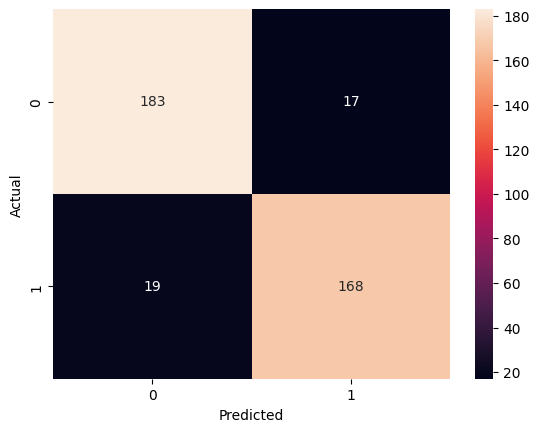

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')